# Importing Required Libraries


In [1]:
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
from datetime import date, timedelta
today = date.today()
import warnings
warnings.filterwarnings("ignore")  

In [2]:
d1 = today.strftime("%Y-%m-%d")
end_date = d1


In [3]:
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

In [4]:
data = yf.download('GOOG', 
                      start=start_date, 
                      end=end_date, 
                      progress=False)


In [5]:
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace=True)
print(data.tail())

          Date        Open        High         Low       Close   Adj Close  \
246 2024-02-13  146.070007  148.039993  145.110001  146.369995  146.369995   
247 2024-02-14  147.369995  147.830002  145.554993  147.139999  147.139999   
248 2024-02-15  144.460007  144.759995  141.880005  143.940002  143.940002   
249 2024-02-16  144.210007  144.479996  141.520004  141.759995  141.759995   
250 2024-02-20  140.940002  143.328995  140.800003  142.199997  142.199997   

       Volume  
246  18138500  
247  16651800  
248  26724300  
249  21849700  
250  18607100  


Resetting index and printing the last few rows of formatted data

In [6]:
data.reset_index(drop=True, inplace=True)
print(data.tail())

          Date        Open        High         Low       Close   Adj Close  \
246 2024-02-13  146.070007  148.039993  145.110001  146.369995  146.369995   
247 2024-02-14  147.369995  147.830002  145.554993  147.139999  147.139999   
248 2024-02-15  144.460007  144.759995  141.880005  143.940002  143.940002   
249 2024-02-16  144.210007  144.479996  141.520004  141.759995  141.759995   
250 2024-02-20  140.940002  143.328995  140.800003  142.199997  142.199997   

       Volume  
246  18138500  
247  16651800  
248  26724300  
249  21849700  
250  18607100  


# We only need the date and close prices columns for the rest of the task, so let’s select both the columns and move further:

In [7]:
data = data[["Date", "Close"]]
print(data.head())

        Date      Close
0 2023-02-21  92.050003
1 2023-02-22  91.800003
2 2023-02-23  91.070000
3 2023-02-24  89.349998
4 2023-02-27  90.099998


# Now let’s visualize the close prices of Google before moving forward:

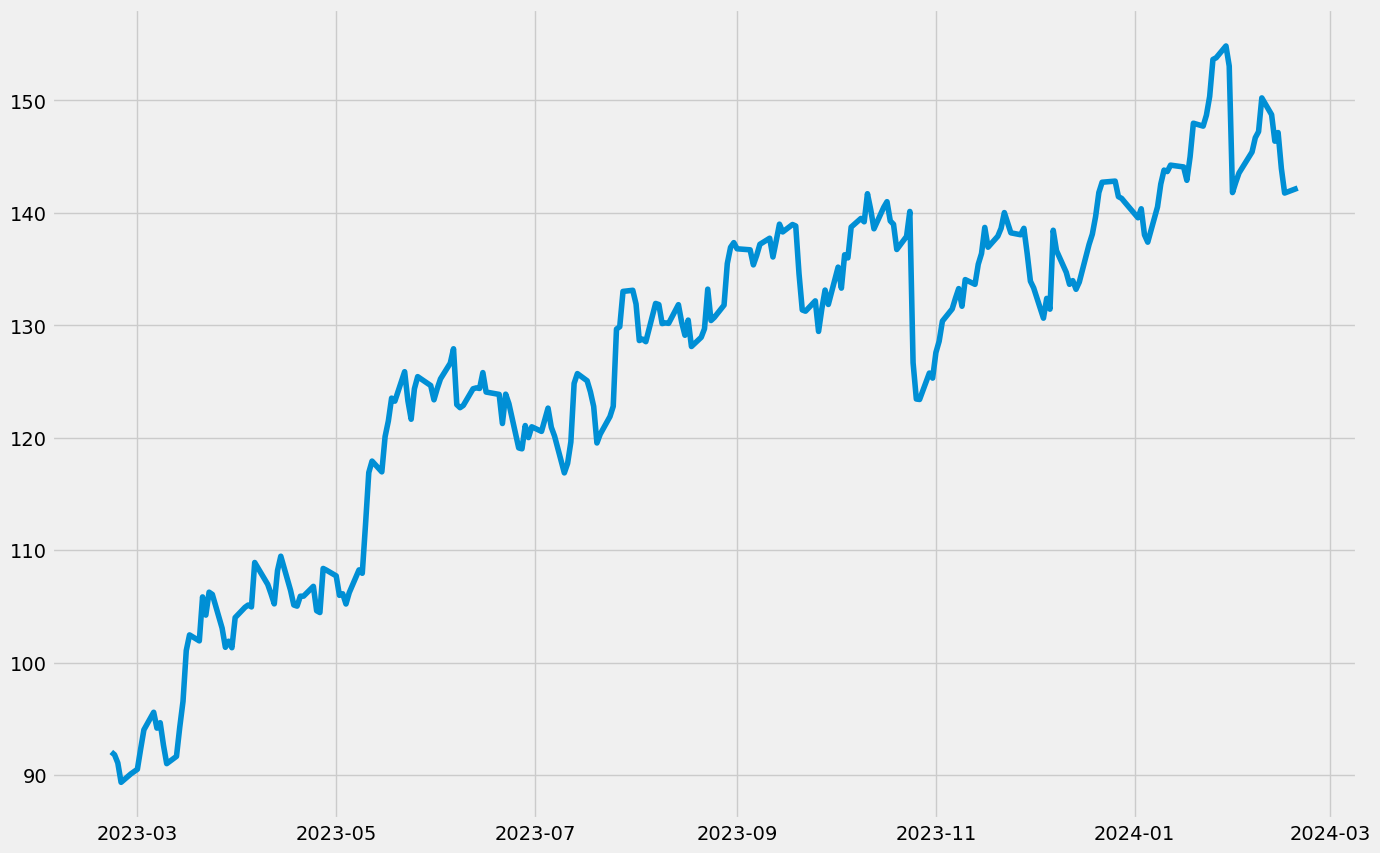

In [8]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

# Using ARIMA for Time Series Forecasting
Before using the ARIMA model, we have to figure out whether our data is stationary or seasonal. The data visualization graph about the closing stock prices above shows that our dataset is not stationary. To check whether our dataset is stationary or seasonal properly, we can use the seasonal decomposition method that splits the time series data into trend, seasonal, and residuals for a better understanding of the time series data:

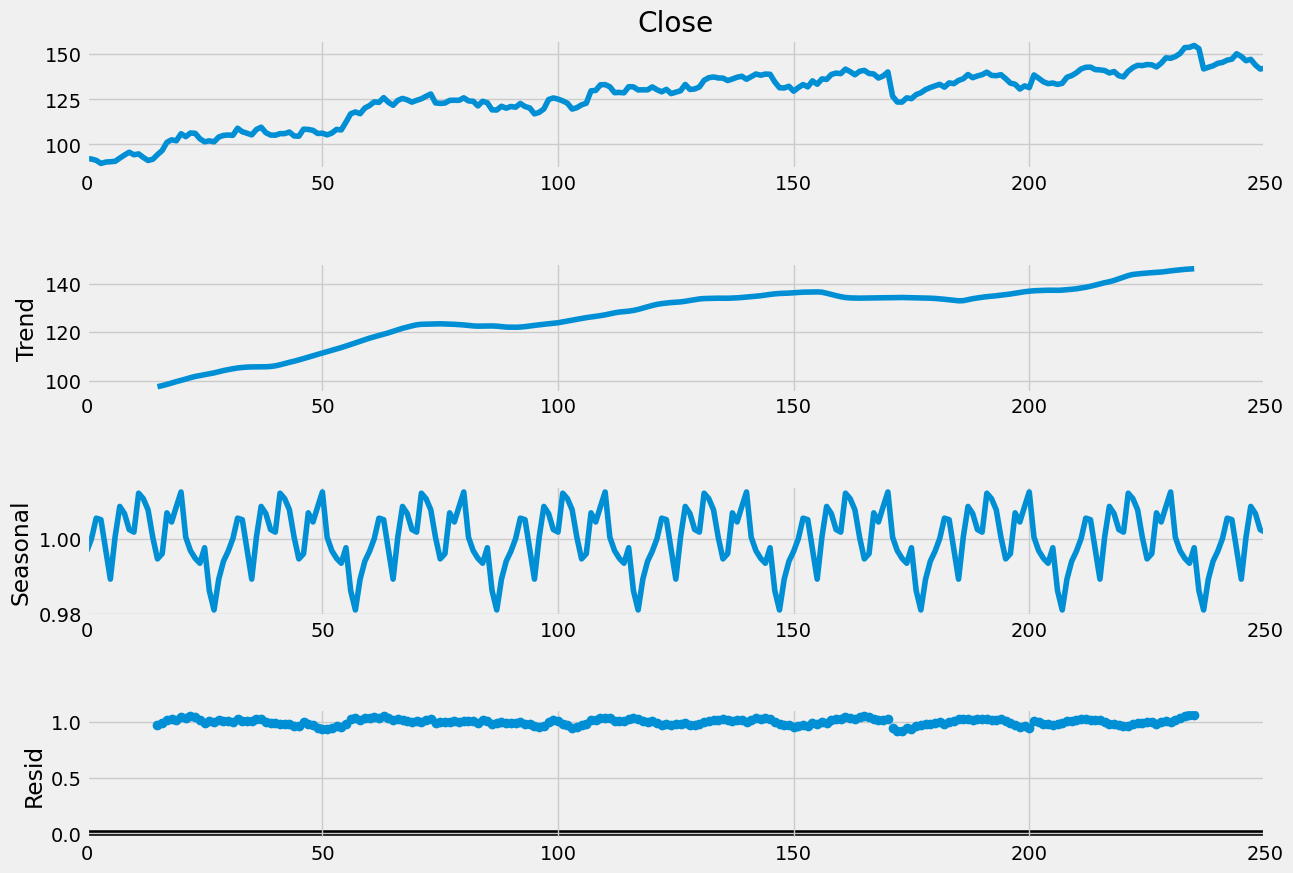

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data["Close"], model='multiplicative', period=30)
fig = result.plot()
fig.set_size_inches(15, 10)


# So our data is not stationary it is seasonal. We need to use the Seasonal ARIMA (SARIMA) model for Time Series Forecasting on this data. But before using the SARIMA model, we will use the ARIMA model. It will help you learn using both models.

To use ARIMA or SARIMA, we need to find the p, d, and q values. We can find the value of p by plotting the autocorrelation of the Close column and the value of q by plotting the partial autocorrelation plot. The value of d is either 0 or 1. If the data is stationary, we should use 0, and if the data is seasonal, we should use 1. As our data is seasonal, we should use 1 as the d value.

Now here’s how to find the value of p:

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

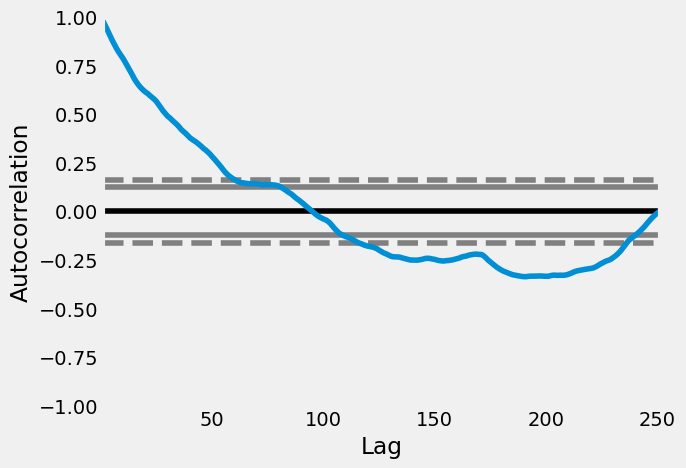

In [10]:
pd.plotting.autocorrelation_plot(data["Close"])

In the above autocorrelation plot, the curve is moving down after the 5th line of the first boundary. That is how to decide the p-value. Hence the value of p is 5. Now let’s find the value of q (moving average):

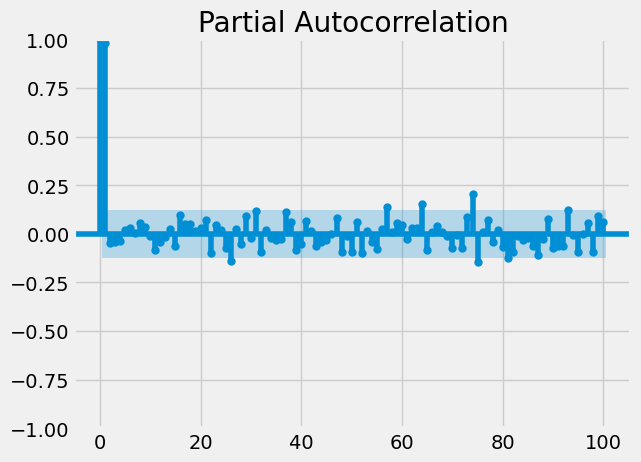

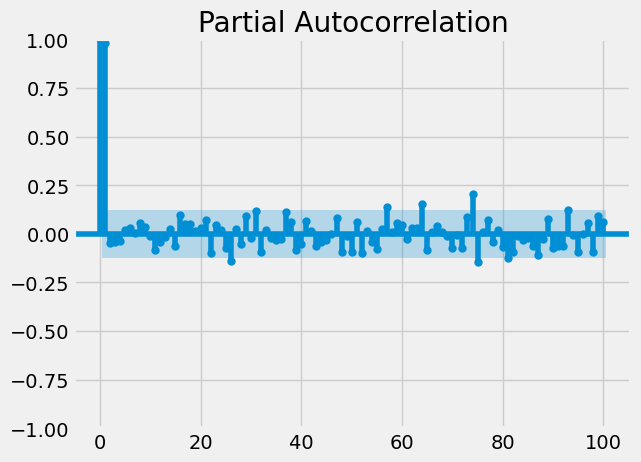

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data["Close"], lags = 100)

In the above partial autocorrelation plot, we can see that only two points are far away from all the points. That is how to decide the q value. Hence the value of q is 2. Now let’s build an ARIMA model:

In [12]:
from statsmodels.tsa.arima.model import ARIMA
p, d, q = 5, 1, 2
model = ARIMA(data["Close"], order=(p, d, q))
fitted = model.fit()
print(fitted.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  251
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -548.293
Date:                Wed, 21 Feb 2024   AIC                           1112.587
Time:                        14:32:09   BIC                           1140.758
Sample:                             0   HQIC                          1123.925
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2950      0.105     12.352      0.000       1.090       1.500
ar.L2         -0.9706      0.142     -6.859      0.000      -1.248      -0.693
ar.L3          0.0046      0.144      0.032      0.9

Here’s how to predict the values using the ARIMA model:

In [13]:
predictions = fitted.predict()
print(predictions)

0        0.000000
1       92.050030
2       91.785086
3       91.027631
4       89.262104
          ...    
246    148.090161
247    145.502279
248    146.963004
249    143.892470
250    141.926298
Name: predicted_mean, Length: 251, dtype: float64


The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time series data. So, here’s how to build a SARIMA model:

In [14]:
import statsmodels.api as sm
import warnings
model=sm.tsa.statespace.SARIMAX(data['Close'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  251
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood                -537.036
Date:                            Wed, 21 Feb 2024   AIC                           1104.072
Time:                                    14:34:40   BIC                           1156.156
Sample:                                         0   HQIC                          1125.062
                                            - 251                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0017      0.439      2.282      0.022       0.142       1.862
ar.L2         -0.4180      0.427   

Now let’s predict the future stock prices using the SARIMA model for the next 10 days:

In [15]:
predictions = model.predict(len(data), len(data)+10)
print(predictions)

251    143.087102
252    144.181953
253    145.490901
254    145.956811
255    145.666624
256    145.416252
257    145.949678
258    145.626851
259    146.229171
260    146.585965
261    146.432208
Name: predicted_mean, dtype: float64


Here’s how you can plot the predictions:

<AxesSubplot:>

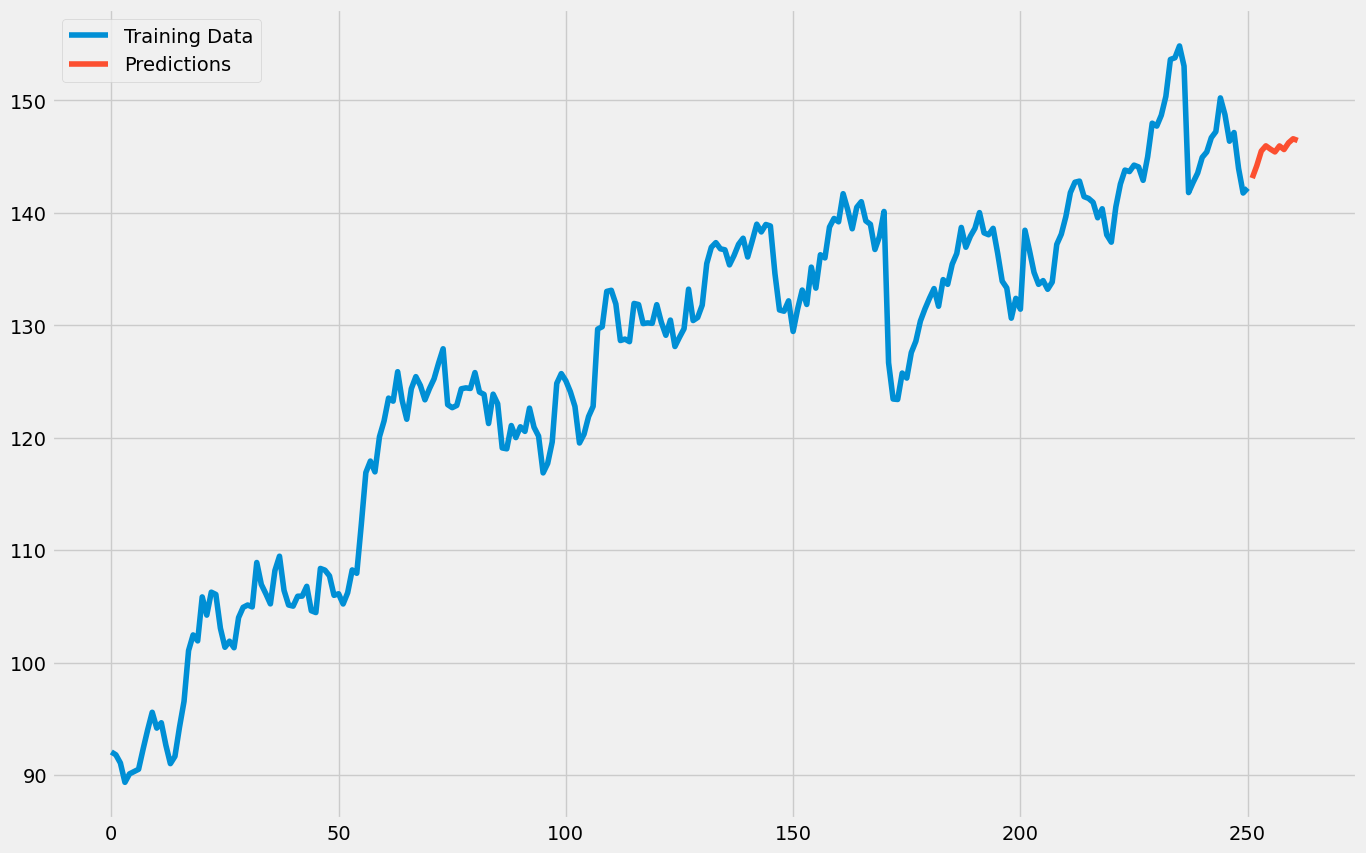

In [16]:
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")

So this is how you can use ARIMA or SARIMA models for Time Series Forecasting using Python.

# Summary
ARIMA stands for Autoregressive Integrated Moving Average. It is an algorithm used for forecasting Time Series Data. If the data is stationary, we need to use ARIMA, if the data is seasonal, we need to use Seasonal ARIMA (SARIMA). I hope you liked this article about Time Series Forecasting with ARIMA using Python. Feel free to ask valuable questions in the comments section below.